In [11]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.layers as initializer
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

In [12]:
from gridworld_v04 import gameEnv
env = gameEnv(partial=False, size=15)
#env.renderEnv()

In [13]:
class Agent():
    def __init__(self, hiddens = [256, 256, 256], num_frames = 4, state_size = 10,
                 action_size = 6, env=None, lr = 1e-3, batch_size = 32, num_episodes = 10000, pre_train_steps = 10000,
                 max_ep_length = 500, buffer_size = 50000, start_e = 1, final_e = 0.01, gamma = 0.99,
                 tau=0.001, update_freq = 5, load_model = False , logs_dir = "./logs_dir"):

        self.hiddens = hiddens # Size of the hidden layers
        self.num_frames = num_frames # Number of consecutive state frames
        self.state_size = state_size # Size of the state vector
        self.action_size = action_size  # Number of actions
        self.env = env # Save the environmet!
        self.lr=lr # learning rate of the optimizer
        self.batch_size=batch_size # Size of the experience sample batch
        self.num_episodes = num_episodes # Number of game environmet episodes in which we train
        self.pre_train_steps = pre_train_steps
        self.max_ep_length = max_ep_length # Maximun length (number of actions) of a single train episode
        self.buffer_size = buffer_size # Size of the experience replay buffer
        self.start_e = start_e # Inital value of the exploration coefficient
        self.final_e = final_e # Final value of the exploration coefficient
        self.gamma = gamma # Discount factor on the target Q-value
        self.tau = tau # Porcentage that determines how much are parameters of mainQN net modified by targetQN
        self.update_freq = update_freq # Frecuency of updates of the double DQN
        self.logs_dir = logs_dir # Path to store logs and checkpoints

        tf.reset_default_graph()

        # Instantiate the networks
        self.mainQN = DQN("mainQN", state_size, action_size, hiddens, num_frames)
        self.targetQN = DQN("targetQN", state_size, action_size, hiddens, num_frames)

        #init = tf.global_variables_initializer()
        trainables = tf.trainable_variables()

        self.target_ops = self.set_target_graph_vars(trainables, tau)

        # Create a experience replay buffer & score records
        self.exp_buffer = ExperienceBuffer()
        self.step_record = [] # for learing process
        self.reward_record = [] # for learnig process
        self.step_record_test = [] # for testing process
        self.reward_record_test = [] # for testing process

        self.model_saver = ModelSaver(self.logs_dir)
        
        self.file_manager = FileManager()
        self.file_name_train = self.logs_dir + "/train_logs"
        self.file_name_test = self.logs_dir + "/test_logs"

    def learn(self):
        print("Model Learning")
        init = tf.global_variables_initializer()
        sess = tf.Session()
        e = self.start_e
        current_step = 0
        
        delimiter = ""
        for _ in range(20):
            delimiter += "-"
        
        #Code for writing to a file?
        #logs_file = self.logs_dir + "/train_logs.txt"
        #with open(logs_file) as fp:
        # -> I made class FileManager below

        with sess:

            sess.run(init)
           # if self.load_model == True:
           #     print('Loading Model...')
           #     model_saver.restore_model(sess)
           #     #ckpt = model_saver_restore_model(sess)

            # Set the target network to be equal to the primary network
            self.update_target_graph(self.target_ops, sess)

            # Start the pre train proces
            for episode in range(self.num_episodes):

                if episode % 100 == 0:
                    print("\n=====" + "Episode " + str(episode) + " starts =====" )

                    
                self.file_manager.write(self.file_name_train, "episode {0}".format(episode+1))    
                episode_exp = ExperienceBuffer()

                #Reset environment and get first new observation
                s = self.env.reset()

                d = False # episode's "done" signal
                episode_reward_sum = 0
                episode_step = 0

                #The Q-Network
                while episode_step < self.max_ep_length: #If the agent take too long to win, end the trial.
                    episode_step += 1

                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    if np.random.rand(1) < e or current_step < self.pre_train_steps:
                        a = np.random.randint(0,4)
                    else:
                        a = sess.run(self.mainQN.predict,feed_dict={self.mainQN.input:[s]})[0]

                    s1,r,d = self.env.step(a)
                    current_step += 1
                    episode_exp.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # Save the experience to our episode buffer.

                    # Start train process
                    if current_step > self.pre_train_steps:

                        if e > self.final_e:
                            stepDrop = 1/10000
                            e -= stepDrop

                        if current_step % self.update_freq == 0:

                            train_batch = self.exp_buffer.sample(self.batch_size) #Get a random batch of experiences.

                            #Perform the Double-DQN update to the target Q-values
                            Q1 = sess.run(self.mainQN.predict,
                                          feed_dict={self.mainQN.input:np.vstack(train_batch[:,3])})

                            Q2 = sess.run(self.targetQN.Qout,
                                          feed_dict={self.targetQN.input:np.vstack(train_batch[:,3])})

                            end_multiplier = -(train_batch[:,4] - 1)
                            doubleQ = Q2[range(self.batch_size),Q1]
                            targetQ = train_batch[:,2] + (self.gamma*doubleQ*end_multiplier)

                            # Update the network with our target values.
                            _ = sess.run(self.mainQN.updateModel,
                                         feed_dict={self.mainQN.input:np.vstack(train_batch[:,0]),
                                         self.mainQN.targetQ:targetQ,
                                         self.mainQN.actions:train_batch[:,1]})

                            # Set the target network to be equal to the primary
                            self.update_target_graph(self.target_ops, sess)

                    episode_reward_sum += r
                    s = s1

                    if d == True:
                        break

                self.exp_buffer.add(episode_exp.buffer)
                self.step_record.append(episode_step)
                self.reward_record.append(episode_reward_sum)

                self.file_manager.write(self.file_name_train, "step_record: "+",".join(str(step) for step in self.step_record))
                self.file_manager.write(self.file_name_train, "reward_record: "+",".join(str(step) for step in self.reward_record))
                
                #Periodically save the model.
                if episode % 1000 == 0:
                    self.model_saver.save_model(sess, episode)
                    print("Model saved")

                if len(self.reward_record) % 10 == 0:
                    partial_reward = np.mean(self.reward_record[-10:])
                    log = str(current_step) +"\t"+ str(partial_reward) +"\t"+ str(e) +"\n"
                    #f.write(log)
                    print("%d %4.2f %3.2f" % (current_step, partial_reward, e))

                self.file_manager.write(self.file_name_train, delimiter)
                
            self.model_saver.save_model(sess, self.num_episodes)
        final_log = "Percent of sucessful episodes: " + str(sum(self.reward_record)/self.num_episodes) + "%"
        print(final_log)

    def test(self):
        current_step = 0
        load_model = True
        num_test_episodes = 5000

        delimiter = ""
        for _ in range(20):
            delimiter += "-"
        
        with tf.Session() as sess:
            if load_model == True:
                print('Loading Model...')
                self.model_saver.restore_model(sess)

            for episode in range(num_test_episodes):
                self.file_manager.write(self.file_name_test, "episode {0}".format(episode+1))    
                
                s = self.env.reset_for_testing()
                d = False
                episode_step = 0
                episode_reword_sum = 0

                #Q-Network
                while episode_step < self.max_ep_length:
                    episode_step += 1
                    a = sess.run(self.mainQN.predict, feed_dict={self.mainQN.input:[s]})[0]
                    s1, r, d = self.env.step_for_testing(a)

                    current_step += 1
                    episode_reword_sum += r
                    s = s1

                    if d == True:
                        break

                self.step_record_test.append(episode_step)
                self.reward_record_test.append(episode_reword_sum)

                self.file_manager.write(self.file_name_test, "step_record_test: "+",".join(str(step) for step in self.step_record_test))
                self.file_manager.write(self.file_name_test, "reward_record_tset: "+",".join(str(step) for step in self.reward_record_test))
                self.file_manager.write(self.file_name_test, delimiter)
                
                # print(episode_reword_sum)

                if len(self.reward_record_test) % 10 == 0:
                    partial_reward = np.mean(self.reward_record_test[-10:])
                    log = str(current_step) +"\t"+ str(partial_reward)
                    #f.write(log)
                    print("%d %4.2f" % (current_step, partial_reward))

        final_log = "Percent of sucessful episodes: " + str(sum(self.reward_record_test)/num_test_episodes) + "%"
        print(final_log)

    """ Auxiliary Methods """
    # Originally called updateTargetGraph
    def set_target_graph_vars(self, tfVars, tau):
        total_vars = len(tfVars)
        op_holder = []

        for idx,var in enumerate(tfVars[0:total_vars//2]): # Select the first half of the variables (mainQ net)
            op_holder.append( tfVars[idx+total_vars//2].assign((var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))

        return op_holder
    # Originally called updateTarget
    def update_target_graph(self, op_holder, sess):
        for op in op_holder:
            sess.run(op)


In [14]:
class DQN():
    def __init__(self, net_name, state_size, action_size, hiddens, num_frames):
        self.net_name = net_name

        with tf.variable_scope(self.net_name):

            self.input = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
            #self.input_state = tf.reshape(self.state, [-1, num_frames * state_size])

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [state_size, hiddens[0]]),
                'W2': self.init_weight("W2", [hiddens[0], hiddens[1]]),
                'W3': self.init_weight("W3", [hiddens[1], hiddens[2]]),
                'AW': self.init_weight("AW", [hiddens[2]//2, action_size]),
                'VM': self.init_weight("VM", [hiddens[2]//2, 1])
            }

            self.b = {
                'b1': self.init_bias("b1", hiddens[0]),
                'b2': self.init_bias("b2", hiddens[1]),
                'b3': self.init_bias("b3", hiddens[2])
            }

            # Layers
            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))

            # Compute the Advantage, Value, and total Q value
            self.A, self.V = tf.split(self.hidden3, 2, 1)
            self.Advantage = tf.matmul(self.A, self.W['AW'])
            self.Value = tf.matmul(self.V, self.W['VM'])
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))

            # Calcultate the action with highest Q value
            self.predict = tf.argmax(self.Qout, 1)

            # Compute the loss (sum of squared differences)
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_one_hot = tf.one_hot(self.actions, action_size, dtype=tf.float32)

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_one_hot), axis=1)
            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)

    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=initializer.xavier_initializer(), dtype=tf.float32)

    def init_bias(self, name, shape):
        return tf.Variable(tf.random_normal([shape]))
        #initializer = tf.constant(np.random.rand(shape))
        #return tf.get_variable(name=name, initializer=initializer, dtype=tf.float32)

In [15]:
class ExperienceBuffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):

        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []

        self.buffer.extend(experience)

    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5])

In [16]:
class ModelSaver():
    def __init__(self, path):
        self.saver = tf.train.Saver()
        self.ckptPath = path
        if not os.path.exists(path):
            os.makedirs(path)

    def restore_model(self, sess):
        ckpt = tf.train.get_checkpoint_state(self.ckptPath)
        self.saver.restore(sess, ckpt.model_checkpoint_path)

    def save_model(self, sess, num_episode):
        self.saver.save(sess, self.ckptPath+'/model-'+str(num_episode)+'.cptk')

In [17]:
class FileManager():
    def __init__(self):
        return 
        # If there is no file, create file with name firstly\n",
        # If there is file with name, append content in the file \n",
    def write(self, name="default_filename", content=""):
        name = name+".txt"
        with open(name, 'a') as f:
            f.write(content)
            f.write('\n')
        return

    def read(self, name="default_filename"):
        name = name+".txt"
        try:
            with open(name, 'r') as f:
                data = f.read()
                return data
        except FileNotFoundError as e:
            print(e)


In [18]:
class DrawGraph(): # simply version
    def __init__(self, reward_record):
        self.reward_record = reward_record
    def plot(self):
        rMat = np.resize(np.array(self.reward_record), [len(self.reward_record)//100,100])           
        rMean = np.average(rMat, 1)
        plt.plot(rMean)

Model Learning

=====Episode 0 starts =====
Model saved
4374 -61.80 1.00
8445 -64.70 1.00
12450 -60.20 0.76
17450 -38.20 0.26
21455 -4.60 0.01
26455 -6.10 0.01
31455 -5.50 0.01
35051 -1.70 0.01
39666 -1.00 0.01
43817 -0.80 0.01

=====Episode 100 starts =====
48817 -2.10 0.01
50729 1.70 0.01
53174 2.50 0.01
55325 2.10 0.01
57527 2.50 0.01
59232 2.10 0.01
60871 3.50 0.01
62461 3.00 0.01
64019 2.10 0.01
65351 3.70 0.01

=====Episode 200 starts =====
66206 3.40 0.01
67986 1.80 0.01
69098 3.20 0.01
70984 2.70 0.01
71606 3.80 0.01
72206 3.70 0.01
73202 3.60 0.01
73647 3.70 0.01
74903 3.50 0.01
75072 3.80 0.01

=====Episode 300 starts =====
76424 2.80 0.01
76917 3.60 0.01
77690 3.40 0.01
78557 3.60 0.01
79572 3.20 0.01
80008 3.50 0.01
80356 3.70 0.01
81063 3.70 0.01
81521 3.60 0.01
82197 2.10 0.01

=====Episode 400 starts =====
82632 3.50 0.01
83158 0.20 0.01
83419 3.80 0.01
83807 3.60 0.01
84253 3.80 0.01
84586 3.90 0.01
84975 3.80 0.01
85323 3.80 0.01
85583 3.80 0.01
85915 3.50 0.01

=====E

144202 4.00 0.01
144402 4.00 0.01
144550 4.00 0.01

=====Episode 4100 starts =====
144732 3.70 0.01
144798 4.00 0.01
144961 3.80 0.01
145074 4.00 0.01
145193 3.90 0.01
145330 3.80 0.01
145451 3.90 0.01
145637 3.80 0.01
145901 3.60 0.01
146169 3.90 0.01

=====Episode 4200 starts =====
146279 3.90 0.01
146372 4.00 0.01
146495 3.90 0.01
146711 3.80 0.01
146876 3.90 0.01
146994 3.90 0.01
147053 4.00 0.01
147166 3.70 0.01
147336 3.70 0.01
147529 3.70 0.01

=====Episode 4300 starts =====
147700 3.90 0.01
147851 3.90 0.01
147939 4.00 0.01
148096 3.90 0.01
148338 3.80 0.01
148519 3.90 0.01
148608 4.00 0.01
148697 4.00 0.01
148807 3.90 0.01
148952 3.90 0.01

=====Episode 4400 starts =====
149044 4.00 0.01
149238 3.90 0.01
149435 3.80 0.01
149579 3.90 0.01
149737 3.90 0.01
149875 3.90 0.01
149982 4.00 0.01
150206 3.60 0.01
150332 3.80 0.01
150418 4.00 0.01

=====Episode 4500 starts =====
150584 3.80 0.01
150686 3.80 0.01
150909 4.00 0.01
151032 3.70 0.01
151153 3.70 0.01
151293 3.80 0.01
151460 

[2017-06-13 05:41:14,005] Restoring parameters from ./logs_dir/model-5000.cptk


1290447 1.60
Percent of sucessful episodes: 1.4908%


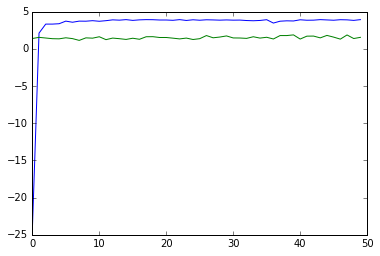

In [21]:
def main():
    env = gameEnv(partial = False, size=15)
        
    # The parameters of Agent class are as follows:
    # hiddens, num_frames, state_size, action_size, env, lr, batch_size, num_episodes, pre_train_steps,
    # max_ep_length, buffer_size, start_e, final_e, gamma, tau, update_freq, load_model, logs_dir
    agent = Agent([256, 256, 256], 1, len(env.mapEnv()), 4, env, 1e-3, 32, 10000, 10000, 500, 50000, 1, 0.01, 0.99, 0.001, 5, False, "./logs_dir")
    agent.learn()
    agent.test()
    
    train_graph = DrawGraph(agent.reward_record)
    test_graph = DrawGraph(agent.reward_record_test)
    
    train_graph.plot()
    test_graph.plot()
    

if __name__ == '__main__':
    main()